# Baltimore Orioles Batter Analysis

In [105]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

In [106]:
#df = pd.read_csv('../../Indep Study- Hitter Analysis/hitter_analysis/CleanedUpForDB.csv')
#df = df[df['pitch_type'].notna()]

#map_player_id = pd.read_excel('SFBB-Player-ID-Map.xlsx')
#map_player_id = map_player_id[map_player_id['TEAM'] == 'BAL']
#map_player_id = map_player_id[['TEAM','MLBID','MLBNAME','POS']]
#map_player_id.rename(columns={'MLBID':'batter'}, inplace=True)
#map_player_id.head()

#bal_df = pd.merge(left=df,
#             right=map_player_id,
#             on='batter')

#to_drop = ['Unnamed: 0','game_date','on_3b','on_2b','on_1b','outs_when_up','balls','strikes','vx0','vy0','vz0','at_bat_number','pitch_number','home_score','away_score','bat_score']
#df.drop(to_drop, inplace=True, axis=1)

#bal_df.to_csv('BAL_2019_season.csv')

In [107]:
# Import data 
df = pd.read_csv('BAL_2019_season.csv')

# remove unnecessary column
df.drop(['Unnamed: 0.1'], inplace=True, axis=1)
# remove null pitch_types
df = df[df['pitch_type'].notna()]
# drop unnecessary cols
to_drop = ['Unnamed: 0','game_date','on_3b','on_2b','on_1b','outs_when_up','balls','strikes','vx0','vy0','vz0','at_bat_number',
           'pitch_number','home_score','away_score','bat_score','release_pos_x','release_pos_z','pfx_x','pfx_z','TEAM','POS',
           'des','release_spin_rate','release_extension','release_pos_y']
df.drop(to_drop, inplace=True, axis=1)

# fix up column datatypes
df['game_pk'] = df['game_pk'].astype(int) # to get rid of the *.0
df['game_pk'] = df['game_pk'].astype(str)
df['sv_id'] = df['sv_id'].astype(str)
df['pitcher'] = df['pitcher'].astype(int) # to get rid of the *.0
df['batter'] = df['batter'].astype(int) # to get rid of the *.0

# switch from catcher's perspective to pitcher's perspective
# Catcher's POV: (plate_x,plate_z)
# Pitcher's POV: (plate_-x,plate_z)
df['plate_-x'] = -df['plate_x']

# rename vague column title
df.rename(columns={'player_name':'pitcher_name'}, inplace=True)
df.rename(columns={'MLBNAME':'batter_name'}, inplace=True)

#df.head() 
#df.shape
#df.columns.tolist()

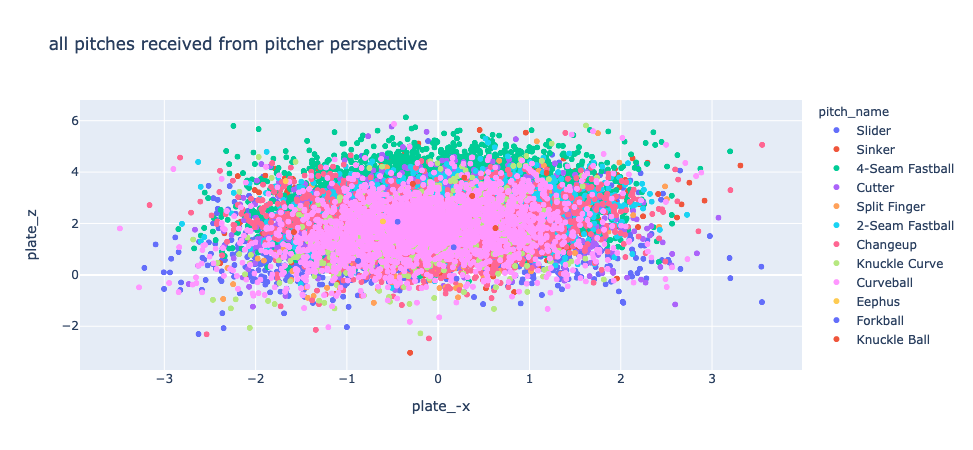

In [108]:
all_pitches_plot = px.scatter(df, x='plate_-x', y='plate_z', 
                              title='all pitches received from pitcher perspective',
                              color='pitch_name',)
# center of plate at ground = (0,0)

all_pitches_plot.show()

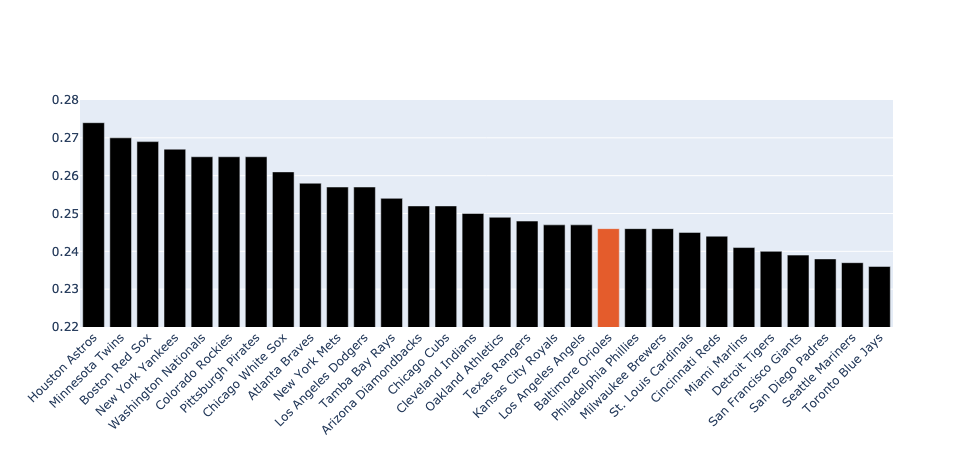

In [109]:
mlb_BA = {'Team': ['Houston Astros','Minnesota Twins','Boston Red Sox','New York Yankees','Washington Nationals','Colorado Rockies','Pittsburgh Pirates','Chicago White Sox','Atlanta Braves','New York Mets','Los Angeles Dodgers','Tamba Bay Rays','Arizona Diamondbacks','Chicago Cubs','Cleveland Indians','Oakland Athletics','Tecxas Rangers','Kansas City Royals','Los Angeles Angels','Baltimore Orioles','Philadelphia Phillies','Milwaukee Brewers','St. Louis Cardinals','Cincinnati Reds','Miami Marlins','Detroit Tigers','San Francisco Giants','San Diego Padres','Seattle Mariners','Toronto Blue Jays'],
         '2019 Batting Averages': ['.274','.270','.269','.267','.265','.265','.265','.261','.258','.257','.257','.254','.252','.252','.250','.249','.248','.247','.247','.246','.246','.246','.245','.244','.241','.240','.239','.238','.237','.236'],
         'colors': ['black']}

df_mlb_BA = pd.DataFrame(mlb_BA, columns = ['Team','2019 Batting Averages'])

# mlb_BA_rank = px.bar(df_mlb_BA, x='2019 Batting Averages', y='Team',
#                      orientation='h')
# mlb_BA_rank.update_yaxes(autorange='reversed')
# mlb_BA_rank.update_traces(marker_color='black')
# mlb_BA_rank.show()

colors = ['black',]*30
colors[19] = '#e45c2c'

mlb_BA_rank = go.Figure(data=[go.Bar(
    y=['.274','.270','.269','.267','.265','.265','.265','.261','.258','.257','.257','.254','.252','.252','.250','.249','.248','.247','.247','.246','.246','.246','.245','.244','.241','.240','.239','.238','.237','.236'],
    x=['Houston Astros','Minnesota Twins','Boston Red Sox','New York Yankees','Washington Nationals','Colorado Rockies','Pittsburgh Pirates','Chicago White Sox','Atlanta Braves','New York Mets','Los Angeles Dodgers','Tamba Bay Rays','Arizona Diamondbacks','Chicago Cubs','Cleveland Indians','Oakland Athletics','Texas Rangers','Kansas City Royals','Los Angeles Angels','Baltimore Orioles','Philadelphia Phillies','Milwaukee Brewers','St. Louis Cardinals','Cincinnati Reds','Miami Marlins','Detroit Tigers','San Francisco Giants','San Diego Padres','Seattle Mariners','Toronto Blue Jays'],
    marker_color = colors)])
# mlb_BA_rank.update_yaxes(autorange='reversed')
mlb_BA_rank.update_layout(xaxis_tickangle=-45)
mlb_BA_rank.update_yaxes(range=[0.22,0.28])
mlb_BA_rank.show()

## Calculate what zone a pitch falls into 

In [110]:
def det_batter_zone(x,z,sz_top,sz_bot):
    sz_mid = ((sz_top - sz_bot)/2) + sz_bot
    sz_third = (sz_top - sz_bot)/3
    # non-competitive pitches
    if (z < 1) or (z > 4) or (x < -1.5) or (x > 1.5):
        return 0 
    # inner strikezone (1-9)
    elif (sz_bot <= z) and (z <= sz_top) and (-0.7 <= x) and (x <= 0.7):
        if (sz_top >= z) and (z > (sz_top-sz_third)):
            if (x <= -0.23):
                return 1
            elif (x <= 0.23):
                return 2
            elif (x <= 0.7):
                  return 3
        elif ((sz_top-sz_third) >= z) and (z > (sz_bot+sz_third)):
            if (x <= -0.23):
                return 4
            elif (x <= 0.23):
                return 5
            elif (x <= 0.7):
                return 6
        elif ((sz_bot+sz_third) >= z) and (z >= sz_bot):
            if (x <= -0.23):
                return 7
            elif (x <= 0.23):
                return 8
            elif (x <= 0.7):
                return 9
    # outer strike zone
    # top row (10-13)
    elif (sz_top < z) and (z <= 4) and (-1.5 <= x) and (x <= 1.5):
        if (x <= -0.7):
            return 10
        elif (x <= 0):
            return 11
        elif (x <= 0.7):
            return 12
        elif (x <= 1.5):
            return 13
    # top middle row (14,15)
    elif (sz_mid < z) and (z <= sz_top):
        if (-1.5 <= x) and (-0.7 > x):
            return 14
        elif (0.7 < x) and (x <= 1.5):
            return 15
    # bottom middle row (16,17)
    elif (sz_bot < z) and (z <= sz_mid):
        if (-1.5 <= x) and (-0.7 > x):
            return 16
        elif (0.7 < x) and (x <= 1.5):
            return 17
    # bottom row (18-21)
    elif (1 <= z) and (z <= sz_bot) and (-1.5 <= x) and (x <= 1.5):
        if (x <= -0.7):
            return 18
        elif (x <= 0):
            return 19
        elif (x <= 0.7):
            return 20
        elif (x <= 1.5):
            return 21
    # null or invalid
    return -1 

## Measure Success of pitch type per zone per batter

* batters is dictionary that maps batter id to zones list
    * zones is list that maps zone num (index) to pitch_types dictionary
        * pitch_types is dictionary that maps type of pitch to counters for hits, fouls, strikes, and total pitches

In [111]:
batters = {}
for row in range(df.shape[0]):
    pitch_zone = det_batter_zone(df.iloc[row]['plate_-x'],
                                 df.iloc[row]['plate_z'],
                                 df.iloc[row]['sz_top'],
                                 df.iloc[row]['sz_bot'])
    
    # don't include null or invalid pitches in zone -1 or switch_hitters
    if (pitch_zone != -1):
        batter_id = df.iloc[row]['batter']
        batter_stand = df.iloc[row]['stand']
        switch_hitter = df.iloc[row]['switch']
        pitch_type = df.iloc[row]['pitch_type']
        pitch_event = df.iloc[row]['events']
        pitch_result = df.iloc[row]['description']
        pitch_speed = df.iloc[row]['release_speed']

        # initialize new batter
        if (batter_id not in batters):
            if switch_hitter == 0:
                batters[batter_id] = [] # init empty zones list
                for z in range(22): # 22 zones (0: noncompetitive, 1-21: strikezone)
                    pitch_types = {} # init empty pitch type dict
                    batters[batter_id].insert(z, pitch_types)
            elif switch_hitter == 1:
                batters[batter_id] = ([],[])
                for z in range(22): # 22 zones (0: noncompetitive, 1-21: strikezone)
                    pitch_types = {} # init empty pitch type dict
                    batters[batter_id][0].insert(z, pitch_types)
                    batters[batter_id][1].insert(z, pitch_types)
                
        # initialize new pitch_type
        if switch_hitter == 0:
            if pitch_type not in batters[batter_id][pitch_zone]:
                batters[batter_id][pitch_zone][pitch_type] = [] #todo: maybe dict?
                for c in range(5): # range is num of counters
                    if c == 0:
                        batters[batter_id][pitch_zone][pitch_type].insert(c, 0)
                    else:
                        batters[batter_id][pitch_zone][pitch_type].insert(c, [0, 0])
        if switch_hitter == 1:
            if batter_stand == 'L':
                if pitch_type not in batters[batter_id][0][pitch_zone]:
                    batters[batter_id][0][pitch_zone][pitch_type] = [] 
                    for c in range(5): # range is num of counters
                        if c == 0:
                            batters[batter_id][0][pitch_zone][pitch_type].insert(c, 0)
                        else:
                            batters[batter_id][0][pitch_zone][pitch_type].insert(c, [0, 0])
            elif batter_stand == 'R':
                if pitch_type not in batters[batter_id][1][pitch_zone]:
                    batters[batter_id][1][pitch_zone][pitch_type] = [] #todo: maybe dict?
                    for c in range(5): # range is num of counters
                        if c == 0:
                            batters[batter_id][1][pitch_zone][pitch_type].insert(c, 0)
                        else:
                            batters[batter_id][1][pitch_zone][pitch_type].insert(c, [0, 0])
        
        
        # Add to counters
        if not switch_hitter:
            # swing and miss
            if pitch_result in ('swinging_strike', 'swinging_strike_blocked'):
                batters[batter_id][pitch_zone][pitch_type][0] += 1 # total
                batters[batter_id][pitch_zone][pitch_type][1][0] += 1 # total misses
                batters[batter_id][pitch_zone][pitch_type][1][1] += pitch_speed
            # swing and foul
            elif pitch_result in ('foul', 'foul_tip'): # foul (runner going) ???
                batters[batter_id][pitch_zone][pitch_type][0] += 1 # total
                batters[batter_id][pitch_zone][pitch_type][2][0] += 1 # total fouls
                batters[batter_id][pitch_zone][pitch_type][2][1] += pitch_speed
             # swing and hit
            elif pitch_result in ('hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'):
                # made contact and obtained a hit
                if pitch_event in ('single', 'double', 'triple', 'home_run'):
                    batters[batter_id][pitch_zone][pitch_type][0] += 1 # total
                    batters[batter_id][pitch_zone][pitch_type][3][0] += 1 # total contact to hit
                    batters[batter_id][pitch_zone][pitch_type][3][1] += pitch_speed
                # made contact and obtained an out
                elif pitch_event not in ('single', 'double', 'triple', 'home_run'):
                    batters[batter_id][pitch_zone][pitch_type][0] += 1 # total
                    batters[batter_id][pitch_zone][pitch_type][4][0] += 1 # total contact to out
                    batters[batter_id][pitch_zone][pitch_type][4][1] += pitch_speed
            # else: # batter didn't swing
        elif switch_hitter:
            if batter_stand == 'L':
                # swing and miss
                if pitch_result in ('swinging_strike', 'swinging_strike_blocked'):
                    batters[batter_id][0][pitch_zone][pitch_type][0] += 1 # total
                    batters[batter_id][0][pitch_zone][pitch_type][1][0] += 1 # total misses
                    batters[batter_id][0][pitch_zone][pitch_type][1][1] += pitch_speed
                # swing and foul
                elif pitch_result in ('foul', 'foul_tip'): # foul (runner going) ???
                    batters[batter_id][0][pitch_zone][pitch_type][0] += 1 # total
                    batters[batter_id][0][pitch_zone][pitch_type][2][0] += 1 # total fouls
                    batters[batter_id][0][pitch_zone][pitch_type][2][1] += pitch_speed
                 # swing and hit
                elif pitch_result in ('hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'):
                    # made contact and obtained a hit
                    if pitch_event in ('single', 'double', 'triple', 'home_run'):
                        batters[batter_id][0][pitch_zone][pitch_type][0] += 1 # total
                        batters[batter_id][0][pitch_zone][pitch_type][3][0] += 1 # total contact to hit
                        batters[batter_id][0][pitch_zone][pitch_type][3][1] += pitch_speed
                    # made contact and obtained an out
                    elif pitch_event not in ('single', 'double', 'triple', 'home_run'):
                        batters[batter_id][0][pitch_zone][pitch_type][0] += 1 # total
                        batters[batter_id][0][pitch_zone][pitch_type][4][0] += 1 # total contact to out
                        batters[batter_id][0][pitch_zone][pitch_type][4][1] += pitch_speed
                # else: # batter didn't swing
            elif batter_stand == 'R':
                # swing and miss
                if pitch_result in ('swinging_strike', 'swinging_strike_blocked'):
                    batters[batter_id][1][pitch_zone][pitch_type][0] += 1 # total
                    batters[batter_id][1][pitch_zone][pitch_type][1][0] += 1 # total misses
                    batters[batter_id][1][pitch_zone][pitch_type][1][1] += pitch_speed
                # swing and foul
                elif pitch_result in ('foul', 'foul_tip'): # foul (runner going) ???
                    batters[batter_id][1][pitch_zone][pitch_type][0] += 1 # total
                    batters[batter_id][1][pitch_zone][pitch_type][2][0] += 1 # total fouls
                    batters[batter_id][1][pitch_zone][pitch_type][2][1] += pitch_speed
                 # swing and hit
                elif pitch_result in ('hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'):
                    # made contact and obtained a hit
                    if pitch_event in ('single', 'double', 'triple', 'home_run'):
                        batters[batter_id][1][pitch_zone][pitch_type][0] += 1 # total
                        batters[batter_id][1][pitch_zone][pitch_type][3][0] += 1 # total contact to hit
                        batters[batter_id][1][pitch_zone][pitch_type][3][1] += pitch_speed
                    # made contact and obtained an out
                    elif pitch_event not in ('single', 'double', 'triple', 'home_run'):
                        batters[batter_id][1][pitch_zone][pitch_type][0] += 1 # total
                        batters[batter_id][1][pitch_zone][pitch_type][4][0] += 1 # total contact to out
                        batters[batter_id][1][pitch_zone][pitch_type][4][1] += pitch_speed
                # else: # batter didn't swing            

In [112]:
# # Non-Switch
# print(batters[641820])
# print()

# # Switch
# print(batters[592859][0])
# print()
# print(batters[592859][1])

In [113]:
switch_hitters = [592859,623993,656775]

In [114]:
def get_color_speed(pitch_count_list):
    # total is when batter swung
    total = pitch_count_list[0]
    # misses
    num_misses = pitch_count_list[1][0]
    sum_speed_misses = pitch_count_list[1][1]
    # fouls
    num_fouls = pitch_count_list[2][0]
    sum_speed_fouls = pitch_count_list[2][1]
    # contact to hits
    num_contact_to_hits = pitch_count_list[3][0]
    sum_speed_hits = pitch_count_list[3][1]
    # contact to outs
    num_contact_to_outs = pitch_count_list[4][0]
    sum_speed_outs = pitch_count_list[4][1]
    
    color = None
    speed = None
    if total > 5:
        if (num_contact_to_hits / total) > 0.33:
            color = "green"
            speed = sum_speed_hits / num_contact_to_hits
        elif((num_fouls + num_misses) / total) > 0.8:
            color = "red"
            speed = (sum_speed_fouls + sum_speed_misses) // (num_fouls + num_misses)
        elif((num_contact_to_outs + num_fouls + num_misses) / total) > 0.75:
            color = "yellow"
            speed = (sum_speed_outs + sum_speed_fouls + sum_speed_misses) // (num_contact_to_outs + num_fouls + num_misses)
    return (color, speed)

In [115]:
# def get_color(pitch_count_list):
#     if len(pitch_count_list) > 5:
#         color = pitch_count_list[5]
#         return color

# def get_speed(pitch_count_list):
#     if len(pitch_count_list) > 5:
#         speed = pitch_count_list[4]
#         return speed

### Weakest Players with most plate appearances

* Renato Núñez: 541 2019 AB - AVG 0.244 --> 600524 [Designated hitter]
* Rio Ruiz: 370 2019 AB - AVG 0.232 --> 547004
* Dwight Smith JR: 357 2019 AB - AVG 0.241 --> 596105 


* Pedro Severino: 305 2019 AB - AVG 0.249 --> 600474 
* Richie Martin: 283 2019 AB - AVG 0.208 --> 621006 

In [116]:
print("Dwight Smith JR 2019 Season")
smith = 596105
print()
for z in range(22):
    print("Zone %s" %z)
    red_pitch_types = []
    yellow_pitch_types = []
    green_pitch_types = []

    for p in batters[smith][z]:
        color, avg_speed = get_color_speed(batters[smith][z][p])
        if color == 'red':
            red_pitch_types.append((p, int(avg_speed)))
        elif color == 'yellow':
            yellow_pitch_types.append((p, int(avg_speed)))
        elif color == 'green':
            green_pitch_types.append((p, int(avg_speed)))

    print("Red: " + str(red_pitch_types))
    print("Yellow: " + str(yellow_pitch_types))
    print("Green: " + str(green_pitch_types))
    print()

Dwight Smith JR 2019 Season

Zone 0
Red: [('SL', 83)]
Yellow: []
Green: []

Zone 1
Red: []
Yellow: []
Green: [('FF', 95)]

Zone 2
Red: []
Yellow: [('FF', 93)]
Green: []

Zone 3
Red: []
Yellow: [('FF', 93)]
Green: []

Zone 4
Red: []
Yellow: []
Green: []

Zone 5
Red: []
Yellow: [('FF', 92), ('SI', 93)]
Green: []

Zone 6
Red: []
Yellow: [('CH', 84), ('SL', 84), ('FF', 93)]
Green: []

Zone 7
Red: []
Yellow: [('FF', 94)]
Green: [('SL', 84)]

Zone 8
Red: []
Yellow: [('SL', 83), ('CH', 85)]
Green: [('FF', 92)]

Zone 9
Red: []
Yellow: [('CH', 84), ('CU', 78)]
Green: []

Zone 10
Red: []
Yellow: []
Green: []

Zone 11
Red: []
Yellow: [('FF', 93)]
Green: []

Zone 12
Red: []
Yellow: []
Green: []

Zone 13
Red: []
Yellow: []
Green: []

Zone 14
Red: []
Yellow: [('FF', 92)]
Green: []

Zone 15
Red: []
Yellow: [('FF', 93)]
Green: []

Zone 16
Red: []
Yellow: [('FF', 93)]
Green: []

Zone 17
Red: []
Yellow: [('CH', 84), ('SL', 84), ('CU', 77)]
Green: []

Zone 18
Red: [('SL', 85)]
Yellow: []
Green: []

Zone 

In [117]:
print("Rio Ruiz 2019 Season")
ruiz = 547004
print()
for z in range(22):
    print("Zone %s" %z)
    red_pitch_types = []
    yellow_pitch_types = []
    green_pitch_types = []

    for p in batters[ruiz][z]:
        color, avg_speed = get_color_speed(batters[ruiz][z][p])
        if color == 'red':
            red_pitch_types.append((p, int(avg_speed)))
        elif color == 'yellow':
            yellow_pitch_types.append((p, int(avg_speed)))
        elif color == 'green':
            green_pitch_types.append((p, int(avg_speed)))

    print("Red: " + str(red_pitch_types))
    print("Yellow: " + str(yellow_pitch_types))
    print("Green: " + str(green_pitch_types))
    print()

Rio Ruiz 2019 Season

Zone 0
Red: [('SL', 86)]
Yellow: []
Green: []

Zone 1
Red: []
Yellow: [('FF', 93)]
Green: []

Zone 2
Red: []
Yellow: [('FF', 92)]
Green: []

Zone 3
Red: []
Yellow: [('FF', 92)]
Green: [('FT', 91)]

Zone 4
Red: []
Yellow: [('FF', 93), ('SL', 85)]
Green: []

Zone 5
Red: []
Yellow: [('FF', 93), ('CU', 79), ('SL', 84), ('SI', 93), ('CH', 84), ('FT', 94)]
Green: []

Zone 6
Red: [('CU', 78)]
Yellow: [('FF', 93), ('FT', 93)]
Green: [('CH', 86)]

Zone 7
Red: []
Yellow: [('SI', 92), ('SL', 84)]
Green: []

Zone 8
Red: []
Yellow: [('SL', 83), ('CU', 79), ('FT', 92), ('FF', 94), ('FC', 89)]
Green: []

Zone 9
Red: [('FT', 92)]
Yellow: [('SL', 85), ('FC', 87), ('CH', 85), ('FF', 94)]
Green: []

Zone 10
Red: []
Yellow: []
Green: []

Zone 11
Red: []
Yellow: [('FF', 93)]
Green: []

Zone 12
Red: []
Yellow: [('FF', 93)]
Green: []

Zone 13
Red: []
Yellow: []
Green: []

Zone 14
Red: []
Yellow: [('FF', 93)]
Green: []

Zone 15
Red: [('FF', 93)]
Yellow: [('CH', 84)]
Green: []

Zone 16
Re

In [118]:
print("Renato Núñez 2019 Season")
nunez = 600524
print()
for z in range(22):
    print("Zone %s" %z)
    red_pitch_types = []
    yellow_pitch_types = []
    green_pitch_types = []

    for p in batters[nunez][z]:
        color, avg_speed = get_color_speed(batters[nunez][z][p])
        if color == 'red':
            red_pitch_types.append((p, int(avg_speed)))
        elif color == 'yellow':
            yellow_pitch_types.append((p, int(avg_speed)))
        elif color == 'green':
            green_pitch_types.append((p, int(avg_speed)))

    print("Red: " + str(red_pitch_types))
    print("Yellow: " + str(yellow_pitch_types))
    print("Green: " + str(green_pitch_types))
    print()

Renato Núñez 2019 Season

Zone 0
Red: [('KC', 81), ('SL', 85), ('FF', 94), ('CH', 84), ('CU', 81)]
Yellow: []
Green: []

Zone 1
Red: []
Yellow: [('FF', 93)]
Green: []

Zone 2
Red: []
Yellow: [('FF', 93)]
Green: []

Zone 3
Red: []
Yellow: [('FF', 93)]
Green: []

Zone 4
Red: []
Yellow: [('SL', 84), ('FF', 94), ('FC', 87), ('CU', 78), ('CH', 83)]
Green: []

Zone 5
Red: []
Yellow: [('SL', 84), ('FF', 94), ('CH', 84), ('SI', 91), ('FC', 87)]
Green: [('CU', 81)]

Zone 6
Red: []
Yellow: [('FF', 93), ('SL', 83), ('FT', 91), ('FC', 88)]
Green: [('SI', 90)]

Zone 7
Red: []
Yellow: [('SL', 85), ('FF', 93)]
Green: [('CU', 80), ('CH', 85)]

Zone 8
Red: [('SL', 84)]
Yellow: [('FC', 86), ('FF', 92), ('CU', 78), ('FT', 91), ('CH', 84)]
Green: [('SI', 92)]

Zone 9
Red: []
Yellow: [('SI', 93), ('FF', 92), ('SL', 83), ('FT', 93)]
Green: []

Zone 10
Red: []
Yellow: []
Green: []

Zone 11
Red: []
Yellow: [('FF', 93)]
Green: []

Zone 12
Red: [('FF', 93)]
Yellow: []
Green: []

Zone 13
Red: []
Yellow: []
Green